## Constructing a galaxy velocity model based on galaxy overdensities

### Finding $f(\delta_g) = v$

The mean absolute peculiar velocity of galaxies within each voxel binned in galaxy overdensity bins is shown below.

In [1]:
import my_functions as mf
import numpy as np
from matplotlib import pyplot as plt

In [2]:
dmo = mf.LoadSimulation('/net/hydra/data2/quinten/data/dmo_fiducial/SOAP-HBT/halo_properties_0077.hdf5')
dmo.selext_galaxies_mass_threshold([10**11, np.inf])
dmo.load_all(128)

Mass range: 11.0 - inf
Galaxies: 7009562


/data2/quinten/.venv4/lib64/python3.12/site-packages/swiftsimio/_array_functions.py:665: RuntimeWarning: Mixing arguments with and without cosmo_factors, continuing assuming provided cosmo_factor (a**0.0 at a=1.0) for all arguments.
  warnings.warn(
/data2/quinten/.venv4/lib64/python3.12/site-packages/swiftsimio/_array_functions.py:430: RuntimeWarning: Mixing arguments with and without cosmo_factors, continuing assuming provided cosmo_factor (a**0.0 at a=1.0) for all arguments.
  warnings.warn(
/data2/quinten/MRP/scripts/my_functions.py:101: RuntimeWarning: invalid value encountered in divide
  voxel_velocity = voxel_velocity_summation / voxel_count


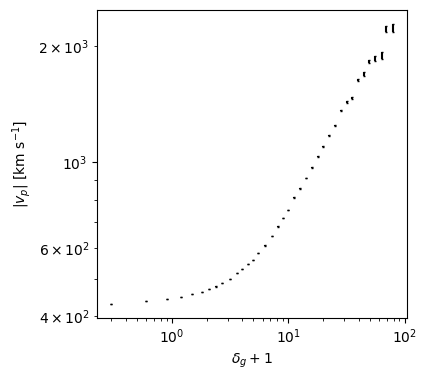

In [3]:
fig, ax = plt.subplots(1,1,figsize=[4,4])

mf.plot_galaxy_overdensity(ax, dmo.number_density_per_galaxy, dmo.mean_galaxy_number_density, dmo.vp_abs)

ax.set(
    xscale='log',
    yscale='log',
    ylabel='$|v_p|$ [km s$^{-1}$]',
    xlabel=r'$\delta_g+1$',
)

plt.show()

This curve is described by two powerlaws stacked together in a nonlinear manner, $$v = \left(c^p + \left(\frac{x}{x_0}\right)^{s\cdot p}\right)^{\frac{1}{p}},$$where $c$ and $\left(\frac{x}{x_0}\right)^{s}$ are the powerlaws and $0 < p < 1$. The best fit is shown below.

/data2/quinten/MRP/scripts/my_functions.py:273: RuntimeWarning: invalid value encountered in power
  return (c**p + (x/x0)**(s*p))**(1/p)


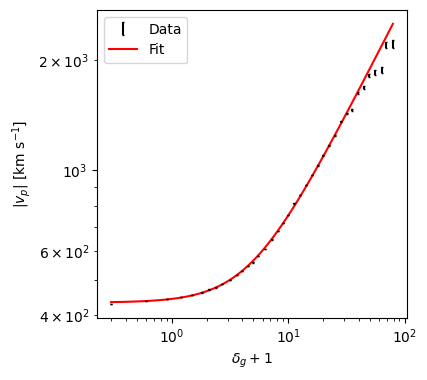

In [4]:
fig, ax = plt.subplots(1,1,figsize=[4,4])

mf.plot_galaxy_overdensity(ax, dmo.number_density_per_galaxy, dmo.mean_galaxy_number_density, dmo.vp_abs, label='Data')
mf.plot_fit_galaxies(ax, dmo.number_density_per_galaxy, dmo.mean_galaxy_number_density, dmo.vp_abs, label='Fit')

ax.set(
    xscale='log',
    yscale='log',
    ylabel='$|v_p|$ [km s$^{-1}$]',
    xlabel=r'$\delta_g+1$',
)
ax.legend()
plt.show()